In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '..', 'vision_fit'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '..', 'vision_analyze'))  # insert parent path

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

import style
cb = '#008fd5'
cr = '#fc4f30'

In [2]:
style.set_style()

In [3]:
import statsmodels.tsa.api as smt

# generate some arma data

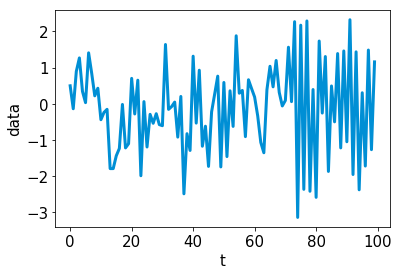

In [55]:
np.random.seed(42)
ar = [1, 0.75, -0.25] # first index is for zero lag
ma = [1, 0.75, 0.25] # first index is for zero lag

n = 100
sample = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, sigma=1)

plt.plot(sample, color=cb)
plt.xlabel('t')
plt.ylabel('data')
plt.show()

# fit and inspect an individual model

In [38]:
p, q = 3, 3
m = smt.ARMA(sample, order=(p, q))
results = m.fit(transparams=False)

In [31]:
ll = results.llf

In [ ]:
print(results.summary())

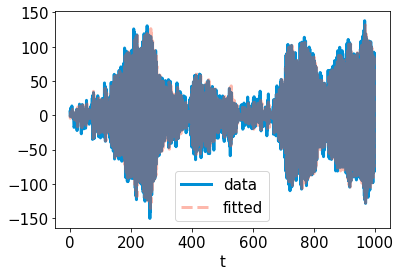

In [21]:
plt.plot(sample, color=cb, label='data')
plt.plot(results.fittedvalues, color=cr, linestyle='--', alpha=0.4, label='fitted')
plt.xlabel('t')
plt.legend()

# try to select given p, q based on complexity measure
**no need for test set since we know the gt params**

In [111]:
def arma_order_select_ic(samples, max_ar=5, max_ma=5, ic=['bic', 'aic'], trend='c',
                         model_kw={}, fit_kw={}):
    '''Try a bunch and see which is best
    '''
    
    results = np.zeros((len(ic), max_ar, max_ma))
    ar_range = np.arange(max_ar) + 1
    ma_range = np.arange(max_ma) + 1
    for ar in ar_range:
        for ma in ma_range:
            mod = smt.ARMA(samples, order=(ar, ma), **model_kw).fit(disp=0, trend=trend, **fit_kw)
            if mod is None:
                results[:, ar - 1, ma - 1] = np.nan
                continue
            ll = mod.llf
            
            for i, criteria in enumerate(ic):
                results[i, ar - 1, ma - 1] = getattr(mod, criteria)
    dfs = [pd.DataFrame(res, columns=ma_range, index=ar_range) for res in results]
    res = dict(zip(ic, dfs))

    # add the minimums to the results dict
    min_res = {}
    for i, k in enumerate(res.keys()):
        result = res[k]
        mins = [x + 1 for x in np.where(result.min().min() == result)] # add 1 because we don't pass 0
        min_res.update({k + '_min_order' : (mins[0][0], mins[1][0])})
    res.update(min_res)

    return res

In [119]:
ar = [1, 0.75, -0.25] # first index is for zero lag
ma = [1, 0.75, 0.25] # first index is for zero lag
n = 100


gt = (len(ar), len(ma)) # p, q
ics = ['bic', 'aic']
correct_arr = {ic: [] for ic in ics}
for i in tqdm(range(10)):
    try:
        sample = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, sigma=0.01)
        results = arma_order_select_ic(sample, max_ar=4, max_ma=4, ic=ics)
        for ic in ics:
            correct_arr[ic].append(results[ic + '_min_order'] == gt)    
    except:
        print('skipped', i)

 10%|█         | 1/10 [00:01<00:17,  1.99s/it]

skipped 0


 20%|██        | 2/10 [00:11<00:32,  4.11s/it]

skipped 1
skipped 2


 40%|████      | 4/10 [00:11<00:17,  2.93s/it]

skipped 3
skipped 4
skipped 5
skipped 6
skipped 7


100%|██████████| 10/10 [00:38<00:00,  6.42s/it]


In [120]:
pd.DataFrame.from_dict(correct_arr)

,bic,aic
0,False,False
1,False,False


In [ ]:
# ar is row, max is col
results['bic']